# Finding datasets that have stopped being updated
This notebook shows how to find datasets that have stopped being updated.
It looks across all datasets and finds the datasets that have been stopped and then 
does analysis with the table types to show which have the highest percentage of being stopped.
This can be extended to find for departments that have stopped releasing certain types of data, what other types are they still releasing.

In [1]:
import openpolicedata as opd
import pandas as pd
import re
import matplotlib.pyplot as plt
opd.__version__

'0.10'

In [2]:
# These are the parameters for the analysis that can be adjusted

# Flag to remove California stops data. Data collection may have stopped when data collection started being handled at the state-level
remove_california_stops_data = True

# Flag to validate that data collection for officer-involved shootings (OIS) has actually stopped by looking for more 
# recent OIS in the Mapping Police Violence data. Since OIS are rare, this helps distinguish cases where OIS just have
# not occurred recently
clean_ois = True

# Flag to create a debug file with removed datasets
create_debug_file = False

# The below parameters are used to configure the final graphs

# These are the minimum and maximum years for what the final graphs will show
analysis_year_min = 1960
analysis_year_max = 2024
up_to_date_dataset_year_max = analysis_year_max - 1  # Datasets whose most recent data is before this year are categorized as having stopped being updated

# This is the minimum number of counts needed to show a table type in the final graphs
minimum_tabletype_counts_to_show = 10

In [3]:
# Helper functions go in this cell
def remove_rows(remove_condition, all_datasets, debug_filename=None):
    
    starting_all_datasets_count = all_datasets.shape[0]
    
    remove_datasets = all_datasets[remove_condition]
        
    # # Drop the identified rows
    all_datasets.drop(remove_datasets.index, inplace=True)
        
    # Verify the number of datasets removed
    assert len(remove_datasets) == (starting_all_datasets_count - all_datasets.shape[0]), \
        "Mismatch in the number of datasets removed"
        
    # Save removed datasets if a debug filename is provided
    if create_debug_file:
        remove_datasets.to_csv(debug_filename, index=True)
    
    return all_datasets

In [4]:
def validate_ois_datasets(df):
    keep = pd.Series(True, index=df.index)

    # Get Mapping Police Violence data. MPV is a pretty thorough tracking of police killings.
    # It does not include OIS but generally should be a good indicator whether an OIS dataset
    # has seized to be updated or there just haven't been any OIS
    src = opd.Source("Mapping Police Violence")
    t = src.load("OFFICER-INVOLVED SHOOTINGS", "MULTIPLE")
    t.standardize()

    df_mpv = t.table

    # Only keep killings via Gunshot. Others might not be included in OIS data
    df_mpv = df_mpv[df_mpv['Cause of death']=='Gunshot']
    
    for i in df[df['TableType']=='OFFICER-INVOLVED SHOOTINGS'].index:
        if df.loc[i,'MaxYear'] >= up_to_date_dataset_year_max:
            continue  # This dataset will be classified as up-to-date

        state_abbrev = opd.defs.states[df.loc[i, 'State']]
        df_mpv_coarse = df_mpv[df_mpv['State']==state_abbrev]  # Filter MPV for OPD state
        # Conservative filtering for OPD agency (only needs to contain partial agency name, not full one)
        df_mpv_coarse = df_mpv_coarse[df_mpv_coarse['AGENCY'].str.lower().str.contains(df.loc[i, 'SourceName'].lower())]

        num_coarse = len(df_mpv_coarse)

        # Clean up MPV agency names
        agencies = df_mpv_coarse['AGENCY'].apply(lambda x: re.sub(rf'\s\(?{state_abbrev}\)?\s', ' ', x, flags=re.IGNORECASE)).str.lower()
        # Filter MPV data for full agency name
        df_mpv_cur = df_mpv_coarse[agencies.str.contains(df.loc[i, 'AgencyFull'].lower())]

        if len(df_mpv_cur)==0:
            if num_coarse>0:
                raise ValueError(f"Unable to find any OIS in the MPV database for {df.loc[i, 'SourceName']}, {state_abbrev}")
        elif df_mpv_cur['DATE'].max().year>df.loc[i,'MaxYear']:
                continue  # MPV agrees that this dataset has stopped being updated

        # MPV data suggests that OPD dataset may be current despite most recent OIS being old
        keep.loc[i] = False
        print(f"{i}: Removing {df.loc[i, 'SourceName']}, {df.loc[i, 'State']}")

    df = remove_rows(remove_condition=~keep,
                     all_datasets=df,
                     debug_filename='removed_ois_datasets.csv')

    return df

In [5]:
# This cell filters out datasets that are not of interest to the analysis

all_datasets_original = opd.datasets.query()
# all_datasets is the filtered dataset with only the rows we are interested in
all_datasets = all_datasets_original.copy()

# Remove datasets where the data is not supplied by the agency itself (such as MuckRock and Stanford)
# supplying_entity is only filled out in this case. Ignore ones where OPD is hosting the data
# OPD only hosts datasets that were released by the agency but the agency removed the data.
all_datasets=remove_rows(remove_condition=all_datasets['supplying_entity'].apply(lambda x: not (pd.isnull(x) or 'OpenPoliceData' in x)),
                        all_datasets=all_datasets,
                        debug_filename="removed_bad_supplying_entity_datasets.csv")


if remove_california_stops_data:
    # Remove all datasets whose State column is equal to California and are of type STOPS
    all_datasets=remove_rows(remove_condition=(all_datasets['State'].str.contains('California') & all_datasets['TableType'].str.contains('STOPS')),
                            all_datasets=all_datasets,
                            debug_filename="removed_california_stops_datasets.csv")


# Remove datasets where the year is not specified
all_datasets=remove_rows(remove_condition=all_datasets['Year']== 'NONE',
                        all_datasets=all_datasets,
                        debug_filename="removed_year_none_datasets.csv")


# Remove datasets with empty coverage dates. This should be redundant with the Year being NONE
all_datasets = remove_rows(remove_condition=all_datasets[['coverage_start', 'coverage_end']].isnull().any(axis=1),
                           all_datasets=all_datasets,
                           debug_filename="empty_coverage.csv")

                  
# focus on the main type for example, change
# "USE OF FORCE - INCIDENTS" and
# "USE OF FORCE - SUBJECTS/OFFICERS"
# to just "USE OF FORCE"
all_datasets['TableType'] = all_datasets['TableType'].str.split(' - ').str[0]

# Combine stops and traffic stops datasets. Also include pedestrian stops.
all_datasets['TableType'] = all_datasets['TableType'].apply(lambda x: 'STOPS' if 'STOPS' in x else x)

print(f"Excluded a total of {all_datasets_original.shape[0] - all_datasets.shape[0]} datasets")


Excluded a total of 285 datasets


In [6]:
# Now we will organize the data to make it easier to analyze
# Since we are interested in types of datasets that have been stopped, we want to focus on coverage start and end dates and table types
selected_columns = ['State', 'SourceName', 'AgencyFull', 'TableType', 'coverage_start', 'coverage_end']
df = all_datasets.copy()

# Create entries for each year instead of a range of years. This will make it easier to filter the data
df['ListOfYears'] = df.apply(
    lambda row: list(range(int(row['coverage_start'].year), int(row['coverage_end'].year) + 1)), axis=1)

# no need for the coverage_start and coverage_end columns since we have the list of years
df = df.drop(columns=['coverage_start', 'coverage_end'])

# find any columns of 'ListOfYears' that are not list objects and print those rows
# There shouldn't be any. This is just a data quality check.
non_list_years = df[~df['ListOfYears'].apply(lambda x: isinstance(x, list))]

if len(non_list_years) > 0:
    raise ValueError(f"Error, the ListOfYears column has {len(non_list_years)} values that are not lists are:\n{non_list_years}")
else:
    pass # do nothing this is just a quality check, everything should be a list

In [7]:
# Focus on organizing up the ListOfYears column

# merge rows that have the same values by extending the 'ListOfYears' column values into a single list
# Specifically this will merge table types that had " - " such as "USE OF FORCE - INCIDENTS" and "USE OF FORCE - SUBJECTS/OFFICERS"
df = df.groupby(['State', 'SourceName', 'TableType', 'AgencyFull']).agg({'ListOfYears': 'sum'}).reset_index()
# remove any duplicate years from the 'ListOfYears' column and sort the list
df['ListOfYears'] = df['ListOfYears'].apply(lambda x: sorted(list(set(x))))

# Data quality check: Ensure that there are no duplicated tables
duplicates = df[df.duplicated(['State', 'SourceName', 'TableType'], keep=False)]
if len(duplicates) > 0:
    print(f"Error, the dataset has {len(duplicates)} duplicate rows. They are:")
    print(duplicates)
else:
    pass # do nothing since just another quality check


# Calculate the minimum and maximum years for each dataset
df['MinYear'] = df['ListOfYears'].apply(min)
df['MaxYear'] = df['ListOfYears'].apply(max)

# Create a label for plotting
df['Label'] = df['SourceName'] + ', ' + df['State'] + ', ' + df['TableType']

# Data quality check: find any rows where the MinYear is greater than the MaxYear or the MinYear is less than analysis_year_min or either the MinYear or MaxYear are not integers
invalid_years = df[(df['MinYear'] > df['MaxYear']) | (df['MinYear'] < analysis_year_min) | (df['MinYear'] % 1 != 0) | (df['MaxYear'] % 1 != 0)]

if len(invalid_years) > 0:
    raise ValueError(f"Error, the dataset has {len(invalid_years)} rows with invalid years. They are:\n{invalid_years}")


In [8]:
if clean_ois:
    # Remove officer-involved shooting (OIS) datasets where there is no recent data and the Mapping Police Violence 
    # database agrees that there have been no recent OIS. This helps account for the potential rarity of OIS.
    num_before = len(df)
    df = validate_ois_datasets(df)
    print(f'Number of officer-involved shootings datasets removed: {num_before-len(df)}\n')

print(f'Number of datasets that will be analyzed: {len(df)}')
df.to_csv('stopped_dataset_analysis_datasets.csv', index=False)

c:\Users\matth\.conda\envs\mpv-dev\Lib\site-packages\openpyxl\packaging\core.py:99: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()


62: Removing Norwich, Connecticut
102: Removing Bloomington, Indiana
Number of officer-involved shootings datasets removed: 2

Number of datasets that will be analyzed: 301


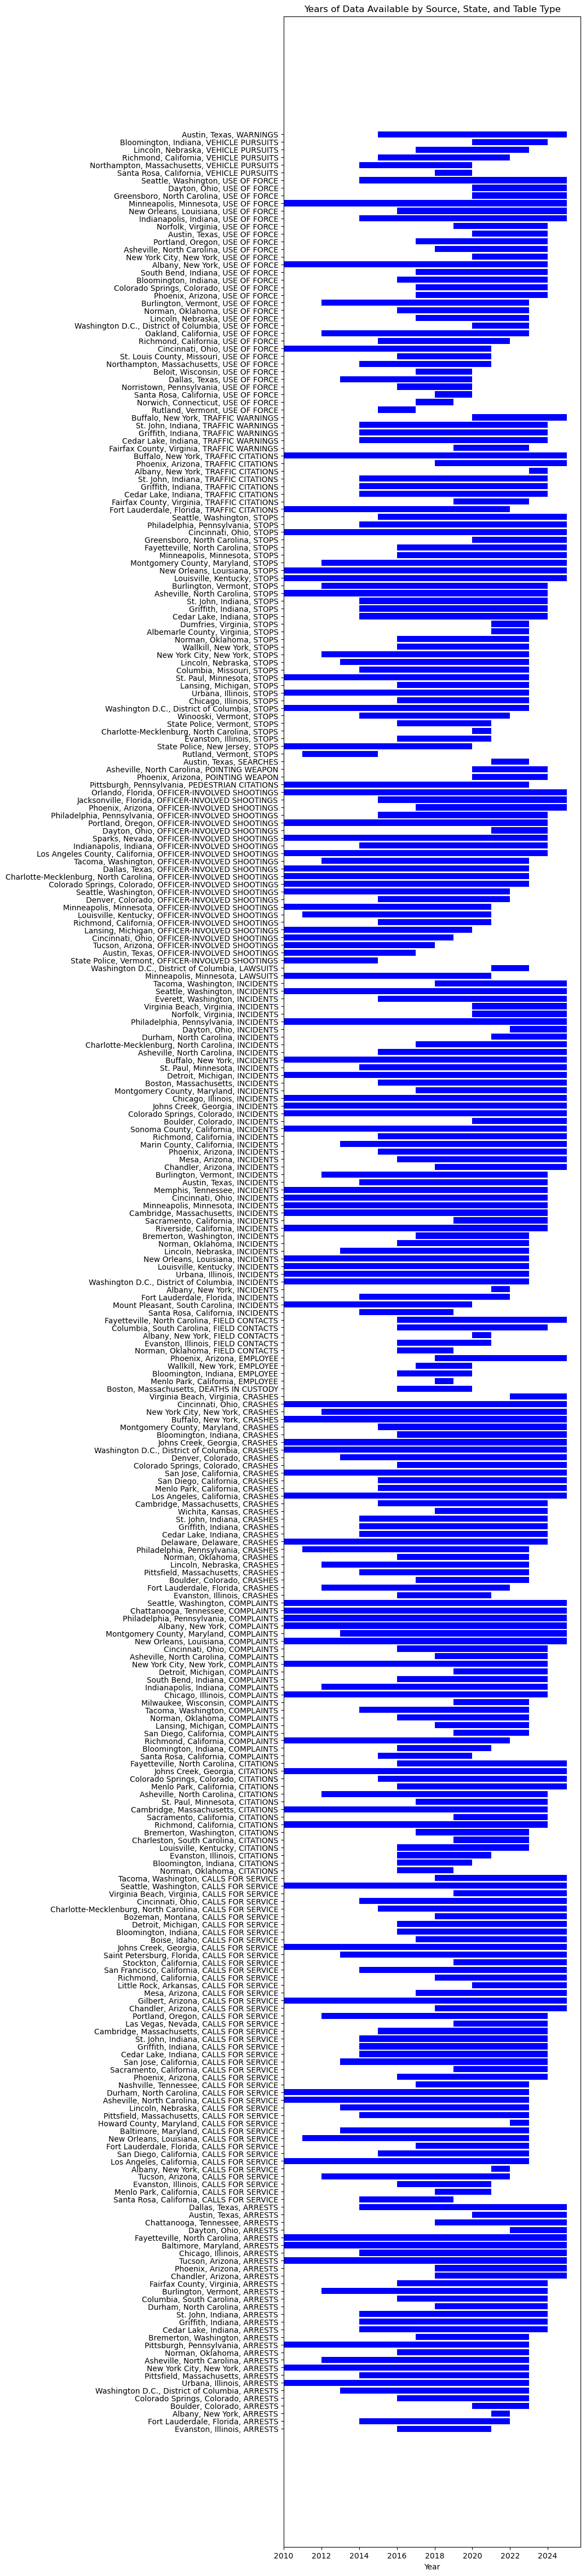

In [9]:
plot_df= df.copy()

# Increase min year to shrink x-limits
min_year = 2010
plot_df['MinYear'] = plot_df['MinYear'].apply(lambda x: min_year if x<min_year else x)

# If the MinYear is the same as the MaxYear, subtract 1 from MinYear to make it viewable 
plot_df['MinYear'] = plot_df.apply(lambda row: row['MinYear'] - 1 if row['MinYear'] == row['MaxYear'] else row['MinYear'], axis=1)

plot_df = plot_df.sort_values(by=['TableType','MaxYear'])

# Plot the data to see the years of data available for each unique combination of 'SourceName', 'State', 'TableType'
plt.figure(figsize=(7, 60))
ax = plt.barh(plot_df['Label'], plot_df['MaxYear'] - plot_df['MinYear'], left=plot_df['MinYear'], color='blue')
plt.xlabel('Year')
plt.title('Years of Data Available by Source, State, and Table Type')
plt.show()

Table type counts >= 10 length is 9. The total number of table types is 20
Number of datasets from the 9 tables is: 266


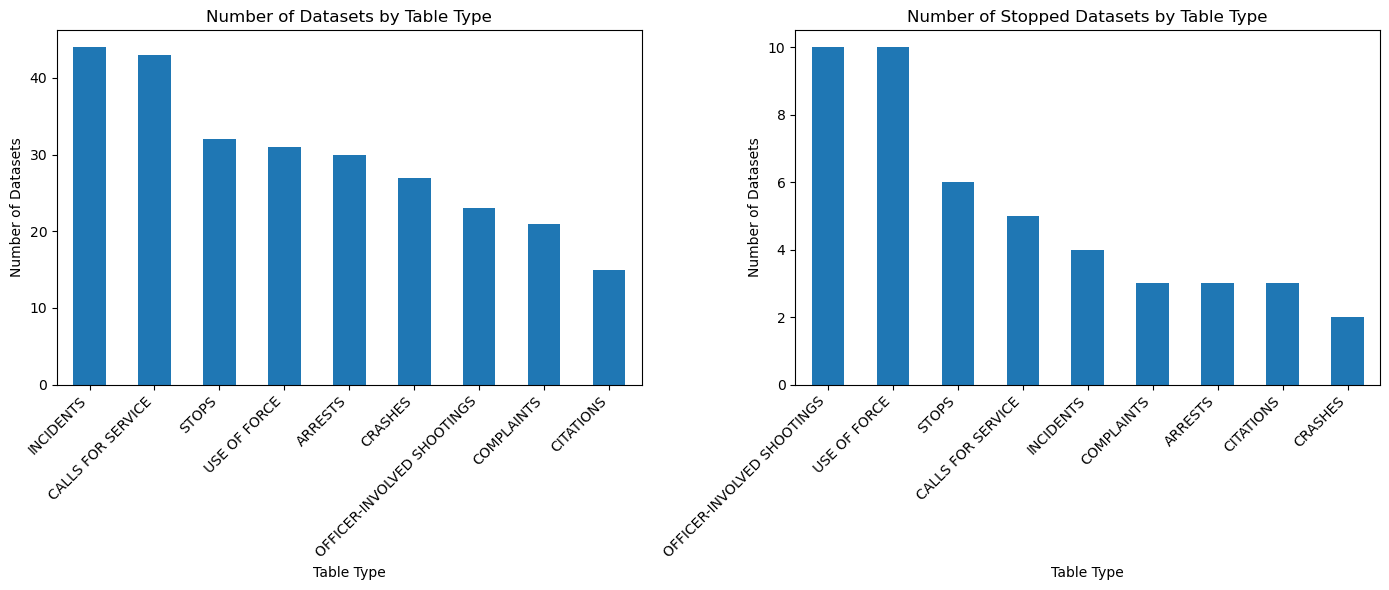

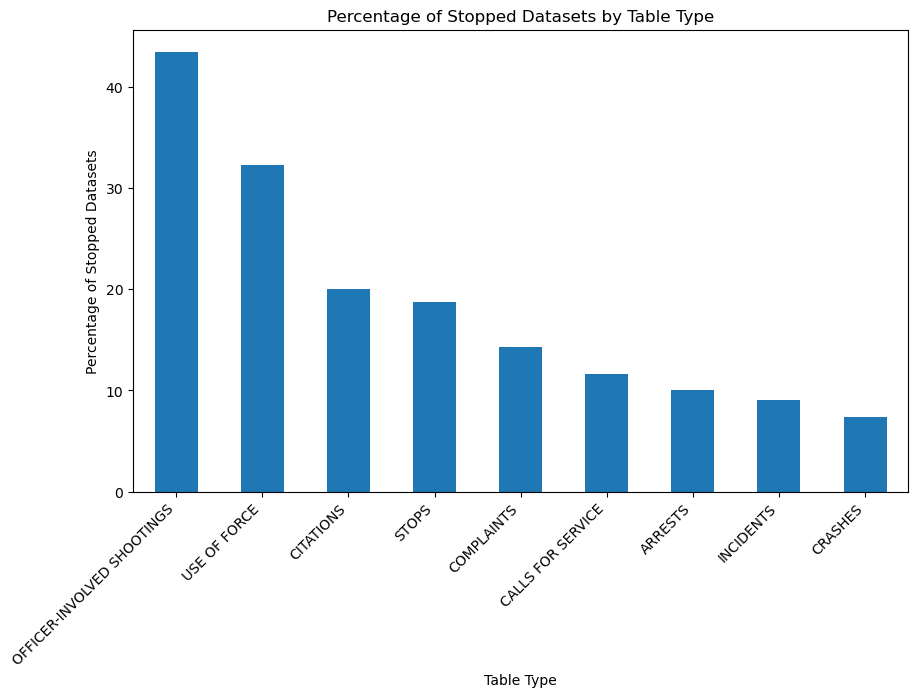

In [10]:
# Find datasets whose most recent year is up_to_date_dataset_year_max or earlier


tabletype_analysis_df = df.copy()
tabletype_counts = tabletype_analysis_df['TableType'].value_counts()

# show only statistically significant table types
total_tabletype_counts = len(tabletype_counts)
tabletype_counts = tabletype_counts[tabletype_counts >= minimum_tabletype_counts_to_show]
print(f"Table type counts >= {minimum_tabletype_counts_to_show} length is {len(tabletype_counts)}. The total number of table types is {total_tabletype_counts}")

# filter out the table types that are not in the tabletype_counts
tabletype_analysis_df = tabletype_analysis_df[tabletype_analysis_df['TableType'].isin(tabletype_counts.index)]

print(f'Number of datasets from the {len(tabletype_counts)} tables is: {len(tabletype_analysis_df)}')

stopped_datasets = tabletype_analysis_df[tabletype_analysis_df['MaxYear'] < up_to_date_dataset_year_max]
stopped_tabletype_counts = stopped_datasets['TableType'].value_counts()


# compute a bar graph histogram of the number of datasets that are stopped by TableType
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

tabletype_counts.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Table Type')
axes[0].set_ylabel('Number of Datasets')
axes[0].set_title('Number of Datasets by Table Type')
axes[0].set_xticklabels(tabletype_counts.index, rotation=45, ha='right')

stopped_tabletype_counts.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Table Type')
axes[1].set_ylabel('Number of Datasets')
axes[1].set_title('Number of Stopped Datasets by Table Type')
axes[1].set_xticklabels(stopped_tabletype_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Find which type has the highest ratio of stopped datasets
percentage_of_stopped_datasets = 100*(stopped_tabletype_counts / tabletype_counts)
percentage_of_stopped_datasets = percentage_of_stopped_datasets.fillna(0)

# Create a bar plot of the ratio and sort the values from high to low
percentage_of_stopped_datasets = percentage_of_stopped_datasets.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = percentage_of_stopped_datasets.plot(kind='bar')
ax.set_xticklabels(percentage_of_stopped_datasets.index, rotation=45, ha='right')
plt.xlabel('Table Type')
plt.ylabel('Percentage of Stopped Datasets')
plt.title('Percentage of Stopped Datasets by Table Type')
plt.show()

<Axes: xlabel='Last Year of Data', ylabel='# of Stopped Datasets'>

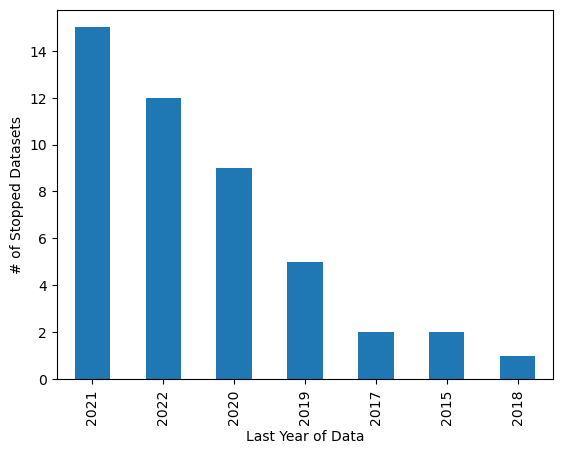

In [16]:
stopped_datasets['MaxYear'].value_counts().plot.bar(ylabel="# of Stopped Datasets", xlabel='Last Year of Data')